In [2]:
import argparse
import copy
from collections import defaultdict
import datetime as dt
import glob
import re
import json
import shutil
import os
import pickle
import yaml
import math
import time
import typing as t
from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms


In [3]:
from memotr.models import build_model
from memotr.data import build_dataset, build_sampler, build_dataloader
from memotr.models.utils import load_pretrained_model
from memotr.models.criterion import build as build_criterion, ClipCriterion
import torch.distributed

from typing import List, Tuple, Dict
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from memotr.models import build_model
from memotr.data import build_dataset, build_sampler, build_dataloader
from memotr.utils.utils import labels_to_one_hot, is_distributed, distributed_rank, set_seed, is_main_process, \
    distributed_world_size
from memotr.utils.nested_tensor import tensor_list_to_nested_tensor
from memotr.models.memotr import MeMOTR
from memotr.structures.track_instances import TrackInstances
from memotr.models.criterion import build as build_criterion, ClipCriterion
from memotr.models.utils import get_model, save_checkpoint, load_checkpoint
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR
from memotr.log.logger import Logger, ProgressLogger
from memotr.log.log import MetricLog
from memotr.models.utils import load_pretrained_model

In [4]:
config=yaml.unsafe_load(open('./train_mot17.yaml'))
config

{'ACCUMULATION_STEPS': 1,
 'ACTIVATION': 'ReLU',
 'AUX_LOSS': True,
 'AUX_LOSS_WEIGHT': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AVAILABLE_GPUS': '0,1,2,3,4,5,6,7',
 'BACKBONE': 'resnet50',
 'BATCH_SIZE': 1,
 'CHECKPOINT_LEVEL': 2,
 'CLIP_MAX_NORM': 0.1,
 'COCO_SIZE': True,
 'CONFIG_PATH': './outputs/memotr_mot17/train/config.yaml',
 'DATASET': 'MOT17',
 'DATA_PATH': None,
 'DATA_ROOT': '/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset',
 'DET_SCORE_THRESH': 0.5,
 'DEVICE': 'cuda',
 'DROPOUT': 0.0,
 'EPOCHS': 130,
 'EVAL_DATA_SPLIT': 'val',
 'EVAL_DIR': None,
 'EVAL_MODE': 'specific',
 'EVAL_MODEL': None,
 'EVAL_PORT': None,
 'EVAL_THREADS': 1,
 'EXTRA_TRACK_ATTN': False,
 'FFN_DIM': 2048,
 'FP_INSERT_RATE': 0.0,
 'GIT_VERSION': None,
 'HIDDEN_DIM': 256,
 'LONG_MEMORY_LAMBDA': 0.01,
 'LOSS_WEIGHT_FOCAL': 2,
 'LOSS_WEIGHT_GIOU': 2,
 'LOSS_WEIGHT_L1': 5,
 'LR': 0.0002,
 'LR_BACKBONE': 2e-05,
 'LR_DROP_MILESTONES': [120],
 'LR_DROP_RATE': 0.1,
 'LR_POINTS': 2e

In [5]:

config['USE_DAB']=True
model = build_model(config=config)

# Load Pretrained Model
if config["PRETRAINED_MODEL"] is not None:
    model = load_pretrained_model(model, config["PRETRAINED_MODEL"], show_details=False)

/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/t7/msc_studies/pose_estimation/related_work/obj_det/MeMOTR/memotr/models/utils.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (Se

Pretrained model is loaded, there are 0 parameters droped and 80 parameters unloaded, set 'show details' True to see more details.


In [6]:
config['DATA_ROOT']='/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset'
config["DATASET"]='MOT17'
config["USE_CROWDHUMAN"]=False
# config["NO_GRAD_FRAMES"]

In [42]:
dataset_train = build_dataset(config=config, split="train")
sampler_train = build_sampler(dataset=dataset_train, shuffle=True)
dataloader_train = build_dataloader(dataset=dataset_train, sampler=sampler_train,
                                    batch_size=1, num_workers=0)


In [50]:
x=dataset_train[55]
x['frame_paths']

['/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset/images/train/MOT17-02-SDP/img1/000056.jpg',
 '/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset/images/train/MOT17-02-SDP/img1/000064.jpg']

In [44]:
x['infos'][0]

{'boxes': tensor([[0.9500, 0.5898, 0.1219, 0.4556],
         [0.3453, 0.5370, 0.0448, 0.2574],
         [0.5586, 0.4981, 0.0193, 0.1019],
         [0.5760, 0.5009, 0.0167, 0.1056],
         [0.6648, 0.4602, 0.0172, 0.0926],
         [0.5359, 0.4620, 0.0208, 0.1074],
         [0.5818, 0.4574, 0.0198, 0.1000],
         [0.4945, 0.4556, 0.0224, 0.1056],
         [0.2794, 0.5532, 0.0589, 0.2898],
         [0.3661, 0.5199, 0.0375, 0.1880],
         [0.7833, 0.4579, 0.0312, 0.1194],
         [0.2833, 0.5435, 0.0458, 0.2444],
         [0.2940, 0.4713, 0.0182, 0.0870],
         [0.2654, 0.4694, 0.0141, 0.0944],
         [0.2284, 0.4639, 0.0203, 0.0778],
         [0.3135, 0.4833, 0.0208, 0.1241],
         [0.5385, 0.4560, 0.0167, 0.0713],
         [0.3456, 0.4792, 0.0193, 0.1139],
         [0.3245, 0.4620, 0.0135, 0.0685],
         [0.3063, 0.4134, 0.0104, 0.0398],
         [0.3146, 0.4111, 0.0094, 0.0389],
         [0.5411, 0.4486, 0.0125, 0.0639],
         [0.3810, 0.4579, 0.0172, 0.0880]]),


In [54]:
x['infos'][0]['ids'], x['infos'][1]['ids']

(tensor([ 1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 15, 16, 17, 20, 25, 28, 29,
         39, 41, 43, 48, 49, 50, 52]),
 tensor([ 2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 25, 26, 28,
         29, 39, 41, 43, 48, 49, 50, 52]))

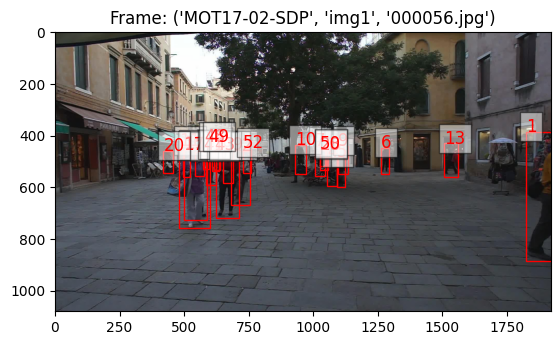

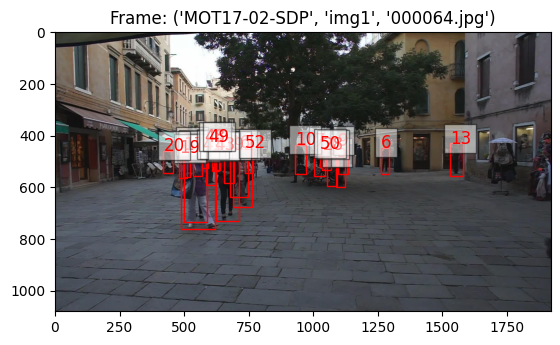

In [56]:

for j in range(len(x["infos"])):
    img = transforms.ToPILImage()(x["infos"][j]["unnorm_img"])
    fig, ax = plt.subplots(1)
    for bidx, box in enumerate( x["infos"][j]["boxes"]):
        img_w, img_h = img.size
        w, h = box[2].item(), box[3].item()
        x_ur, y_ur = (box[0].item() - w / 2) * img_w, (box[1].item() - h / 2) * img_h
        rect = plt.Rectangle((x_ur, y_ur), w*img_w, h*img_h, fill=False, edgecolor="red", linewidth=1)
        ax.add_patch(rect)
        # add text 'j'
        ax.text(x_ur, y_ur, x["infos"][j]['ids'][bidx].item(), fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.5))

    ax.set_title(f"Frame: {Path(x['frame_paths'][j]).parts[-3:]}")
    plt.imshow(img)
    plt.show()
# for i in range(len(batch["infos"])):
#     for j in range(len(batch["infos"][i])):
#         img = transforms.ToPILImage()(batch["infos"][i][j]["unnorm_img"])
#         fig, ax = plt.subplots(1)
#         for box in batch["infos"][i][j]["boxes"]:
#             img_w, img_h = img.size
#             w, h = box[2].item(), box[3].item()
#             x, y = (box[0].item() - w / 2) * img_w, (box[1].item() - h / 2) * img_h
#             rect = plt.Rectangle((x, y), w*img_w, h*img_h, fill=False, edgecolor="red", linewidth=1)
#             ax.add_patch(rect)
#         plt.imshow(img)
#         plt.show()

In [41]:
x["infos"][j]["boxes"]

tensor([[1762.,  388., 1966.,  884.],
        [ 622.,  443.,  710.,  717.],
        [1054.,  483., 1091.,  593.],
        [1090.,  484., 1122.,  598.],
        [1260.,  447., 1293.,  547.],
        [1008.,  441., 1048.,  557.],
        [1098.,  440., 1136.,  548.],
        [ 928.,  435.,  971.,  549.],
        [ 480.,  439.,  593.,  757.],
        [ 670.,  458.,  743.,  664.],
        [1486.,  430., 1542.,  559.],
        [ 500.,  454.,  588.,  721.],
        [ 547.,  462.,  582.,  556.],
        [ 496.,  456.,  524.,  558.],
        [ 419.,  459.,  458.,  543.],
        [ 582.,  455.,  622.,  589.],
        [1019.,  454., 1051.,  531.],
        [ 646.,  456.,  683.,  579.],
        [ 610.,  462.,  636.,  536.],
        [ 578.,  424.,  598.,  467.],
        [ 595.,  423.,  613.,  465.],
        [1027.,  450., 1051.,  519.],
        [ 719.,  447.,  752.,  543.]])

In [14]:
x["infos"][j]

TypeError: 'float' object is not subscriptable

In [14]:
len(dataset_train)
dataset_train


------------------------------
self: <class 'memotr.data.mot17.MOT17'>
config: {'ACCUMULATION_STEPS': 1, 'ACTIVATION': 'ReLU', 'AUX_LOSS': True, 'AUX_LOSS_WEIGHT': [1.0, 1.0, 1.0, 1.0, 1.0], 'AVAILABLE_GPUS': '0,1,2,3,4,5,6,7', 'BACKBONE': 'resnet50', 'BATCH_SIZE': 1, 'CHECKPOINT_LEVEL': 2, 'CLIP_MAX_NORM': 0.1, 'COCO_SIZE': True, 'CONFIG_PATH': './outputs/memotr_mot17/train/config.yaml', 'DATASET': 'MOT17', 'DATA_PATH': None, 'DATA_ROOT': '/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset', 'DET_SCORE_THRESH': 0.5, 'DEVICE': 'cuda', 'DROPOUT': 0.0, 'EPOCHS': 130, 'EVAL_DATA_SPLIT': 'val', 'EVAL_DIR': None, 'EVAL_MODE': 'specific', 'EVAL_MODEL': None, 'EVAL_PORT': None, 'EVAL_THREADS': 1, 'EXTRA_TRACK_ATTN': False, 'FFN_DIM': 2048, 'FP_INSERT_RATE': 0.0, 'GIT_VERSION': None, 'HIDDEN_DIM': 256, 'LONG_MEMORY_LAMBDA': 0.01, 'LOSS_WEIGHT_FOCAL': 2, 'LOSS_WEIGHT_GIOU': 2, 'LOSS_WEIGHT_L1': 5, 'LR': 0.0002, 'LR_BACKBONE': 2e-05, 'LR_DROP_MILESTONES': 

In [9]:
b=next(iter(dataloader_train))

In [12]:
b
len(b['imgs'])

1

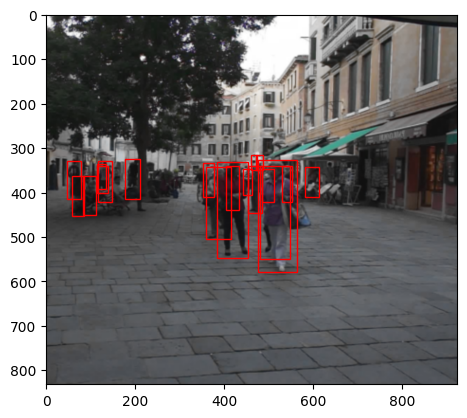

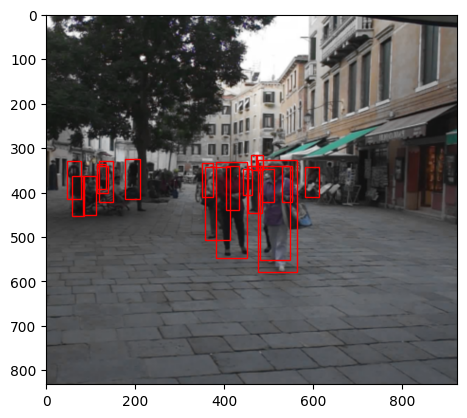

In [11]:
from memotr.utils.tools import visualize_a_batch


b['infos']
b['frame_paths']
visualize_a_batch(b)

In [8]:

criterion = build_criterion(config=config)
criterion.set_device(torch.device("cuda", 0))

In [ ]:
import cv2
import time
import os.path
import sys
import numpy as np
from memotr.models import build_model
from memotr.models.utils import load_checkpoint
from memotr.utils.utils import yaml_to_dict

import torch
from typing import List
from memotr.models import build_model
from memotr.models.utils import load_checkpoint, get_model
from memotr.models.runtime_tracker import RuntimeTracker
from memotr.utils.utils import (
    yaml_to_dict,
    is_distributed,
    distributed_world_size,
    distributed_rank,
    inverse_sigmoid,
)
from memotr.utils.nested_tensor import tensor_list_to_nested_tensor
from memotr.utils.box_ops import box_cxcywh_to_xyxy
from memotr.structures.track_instances import TrackInstances

import torchvision.transforms.functional as F




def demo_processing(
    model,
    config,
    video_path: str,
):
    model.eval()
    print("Model loaded.")
    current_time = time.localtime()
    cap = cv2.VideoCapture(video_path)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
    fps = cap.get(cv2.CAP_PROP_FPS)
    timestamp = time.strftime("%Y_%m_%d_%H_%M_%S", current_time)
    save_folder = os.path.join("./cache/", timestamp)
    save_path = os.path.join(save_folder, "output.avi")
    os.makedirs(save_folder, exist_ok=True)
    vid_writer = cv2.VideoWriter(
        save_path, cv2.VideoWriter_fourcc(*"MJPG"), fps, (int(width), int(height))
    )
    print((int(width), int(height)))

    result_score_thresh = 0.5

    timer = Timer()
    frame_id = 0

    tracks = [
        TrackInstances(
            hidden_dim=model.hidden_dim,
            num_classes=model.num_classes,
            use_dab=config["USE_DAB"],
        ).to("cuda")
    ]
    tracker = RuntimeTracker(
        det_score_thresh=0.5,
        track_score_thresh=0.5,
        miss_tolerance=30,
        use_motion=False,
        motion_min_length=0,
        motion_max_length=0,
        visualize=False,
        use_dab=config["USE_DAB"],
    )

    with torch.no_grad():
        while True:
            if frame_id % 20 == 0:
                print(
                    "Processing frame {} ({:.2f} fps)".format(
                        frame_id, 1.0 / max(1e-5, timer.average_time)
                    )
                )
            if frame_id >=40:
                break
            ret_val, ret_frame = cap.read()
            # online_im = ret_frame
            if ret_val:
                image = process_image(ret_frame)
                frame = tensor_list_to_nested_tensor([image[0]]).to("cuda")
                timer.tic()
                res = model(frame=frame, tracks=tracks)
                previous_tracks, new_tracks = tracker.update(
                    model_outputs=res, tracks=tracks
                )
                # print(previous_tracks[0])
                tracks: List[TrackInstances] = model.postprocess_single_frame(
                    previous_tracks, new_tracks, None
                )

                tracks_result = tracks[0].to(torch.device("cpu"))
                # ori_h, ori_w = ori_image.shape[1], ori_image.shape[2]
                ori_h, ori_w = height, width
                # box = [x, y, w, h]
                tracks_result.area = (
                    tracks_result.boxes[:, 2]
                    * ori_w
                    * tracks_result.boxes[:, 3]
                    * ori_h
                )
                tracks_result = filter_by_score(
                    tracks_result, thresh=result_score_thresh
                )
                tracks_result = filter_by_area(tracks_result)
                # to xyxy:
                tracks_result.boxes = box_cxcywh_to_xyxy(tracks_result.boxes)
                tracks_result.boxes = tracks_result.boxes * torch.as_tensor(
                    [ori_w, ori_h, ori_w, ori_h], dtype=torch.float
                )
                online_tlwhs, online_ids = [], []
                for i in range(len(tracks_result)):
                    x1, y1, x2, y2 = tracks_result.boxes[i].tolist()
                    w, h = x2 - x1, y2 - y1
                    online_tlwhs.append([x1, y1, w, h])
                    online_ids.append(tracks_result.ids[i].item())
                timer.toc()
                if len(online_tlwhs) > 0:
                    online_im = plot_tracking(
                        ret_frame,
                        online_tlwhs,
                        online_ids,
                        frame_id=frame_id + 1,
                        fps=1.0 / timer.average_time,
                    )
                else:
                    online_im = ret_frame
                vid_writer.write(online_im)
                ch = cv2.waitKey(1)
                if ch == 27 or ch == ord("q") or ch == ord("Q"):
                    break
            else:
                break
            frame_id += 1
    return os.path.join(save_folder, "output.avi")

demo_processing(model=model, config=config, video_path='/media/master/t7/msc_studies/pose_estimation/related_work/obj_det/trackformer/data/snakeboard/snakeboard.mp4')

Model loaded.
(1280, 720)
Processing frame 0 (100000.00 fps)


/opt/miniconda3/envs/pt/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing frame 20 (4.86 fps)
Processing frame 40 (5.47 fps)


'./cache/2025_02_12_23_54_39/output.avi'

# train

In [11]:
from pose_tracking.utils.misc import free_cuda_mem


free_cuda_mem()

In [12]:
config['USE_DAB']=False
model = build_model(config=config)

In [ ]:
model.train()
device = torch.device("cuda", 0)
tracks = TrackInstances.init_tracks(
    batch=b,
    hidden_dim=get_model(model).hidden_dim,
    num_classes=get_model(model).num_classes,
    device=device,
    use_dab=True,
)
criterion.init_a_clip(
    batch=b,
    hidden_dim=get_model(model).hidden_dim,
    num_classes=get_model(model).num_classes,
    device=device,
)
for frame_idx in tqdm(range(len(b["imgs"][0]))):
    frame = [fs[frame_idx] for fs in b["imgs"]]
    for f in frame:
        f.requires_grad_(False)
    frame = tensor_list_to_nested_tensor(tensor_list=frame).to(device)
    res = model(frame=frame, tracks=tracks)
    previous_tracks, new_tracks, unmatched_dets = criterion.process_single_frame(
        model_outputs=res, tracked_instances=tracks, frame_idx=frame_idx
    )
    if frame_idx < len(b["imgs"][0]) - 1:
        tracks = model.postprocess_single_frame(
            previous_tracks, new_tracks, unmatched_dets
        )

  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
frame.tensors.shape, tracks[0].frame_height

(torch.Size([1, 3, 640, 1152]), 1.0)

In [24]:

loss_dict, log_dict = criterion.get_mean_by_n_gts()
loss = criterion.get_sum_loss_dict(loss_dict=loss_dict)

In [26]:
loss_dict

{'box_l1_loss': tensor(0.0993, device='cuda:0', grad_fn=<DivBackward0>),
 'box_giou_loss': tensor(0.7599, device='cuda:0', grad_fn=<DivBackward0>),
 'label_focal_loss': tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_box_l1_loss': tensor(0.4417, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_box_giou_loss': tensor(3.7987, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_label_focal_loss': tensor(1.8470, device='cuda:0', grad_fn=<DivBackward0>)}

In [15]:
from train_engine import get_param_groups
param_groups, lr_names = get_param_groups(config=config, model=model)
optimizer = AdamW(params=param_groups, lr=config["LR"], weight_decay=config["WEIGHT_DECAY"])
loss.backward()
accumulation_steps=1
max_norm=0.1
if (0 + 1) % accumulation_steps == 0:
    if max_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    else:
        pass
    optimizer.step()
    optimizer.zero_grad()

In [11]:
model

MeMOTR(
  (backbone): BackboneWithPE(
    (backbone): Backbone(
      (backbone): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d

In [12]:
print(f"model.parameters={sum(p.numel() for p in model.parameters() if p.requires_grad)}")

model.parameters=50013984
